In [26]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [33]:
# Constants
NSHARDS = 10
RESULTS_DIR = '../../mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN', 'GraphSAGE', 'SGC', 'MLP', 'HGCN']
METRIC = 'accuracy_score'

In [39]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [40]:
results_df.head(10)

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,GraphSAGE__model_num_layers,GraphSAGE__model_dropout,GraphSAGE__model_out_channels,HGCN__train_epochs,HGCN__train_lr,HGCN__model_in_channels,HGCN__model_hidden_channels,HGCN__model_num_layers,HGCN__model_dropout,HGCN__model_out_channels
2,461,10.108459,1.372191,16,2.0,2,9.182274,4,0.325791,3.0,...,4,0.0,4,50,0.0010,16,16,2,0.0,4
4,160,8.237500,3.748663,16,2.0,2,31.591777,4,0.086048,3.0,...,3,0.3,4,50,0.0001,16,16,3,0.0,4
5,382,11.287958,2.407173,16,2.0,2,36.195388,4,0.580031,3.0,...,1,0.5,4,50,0.0010,16,4,2,0.0,4
6,339,11.775148,1.114321,16,2.0,2,57.420085,4,0.545945,3.0,...,4,0.8,4,50,0.0100,16,4,2,0.8,4
7,431,9.929907,1.648110,16,2.0,2,55.618552,4,0.766470,3.0,...,3,0.5,4,50,0.0100,16,4,4,0.8,4
0,495,11.450505,4.433238,16,2.0,2,59.813768,4,0.098671,3.0,...,4,0.0,4,50,0.0001,16,16,1,0.0,4
1,221,11.536364,4.843895,16,2.0,2,3.653422,4,0.058417,3.0,...,4,0.5,4,50,0.0100,16,4,4,0.8,4
2,343,10.029325,1.448911,16,2.0,2,45.809511,4,0.630091,3.0,...,4,0.8,4,50,0.0100,16,8,1,0.0,4
4,329,12.395137,4.857145,16,2.0,2,1.162842,4,0.353932,3.0,...,3,0.8,4,50,0.0100,16,16,2,0.0,4
5,318,11.547170,3.083759,16,2.0,2,15.251149,4,0.792478,3.0,...,2,0.8,4,50,0.0100,16,8,1,0.5,4


In [41]:
results_df.columns

Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'generator_name', 'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc',
       'skipped', 'sample_id', 'GCN__val_accuracy', 'GCN__val_f1_micro',
       'GCN__val_f1_macro', 'GCN__val_rocauc_ovr', 'GCN__val_rocauc_ovo',
       'GCN__val_logloss', 'GCN__test_accuracy', 'GCN__test_f1_micro',
       'GCN__test_f1_macr

In [42]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s__%s' % (model, metric)
    if model_metric not in results_df.columns:
      print('Skipping model %s because it does not have metric %s' % (model, metric)) 
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

In [43]:
METRIC = 'test_accuracy'

Skipping model SGC because it does not have metric test_accuracy
Skipping model MLP because it does not have metric test_accuracy


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_62762/1556232042.py:77: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 99)` for the same effect.

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)


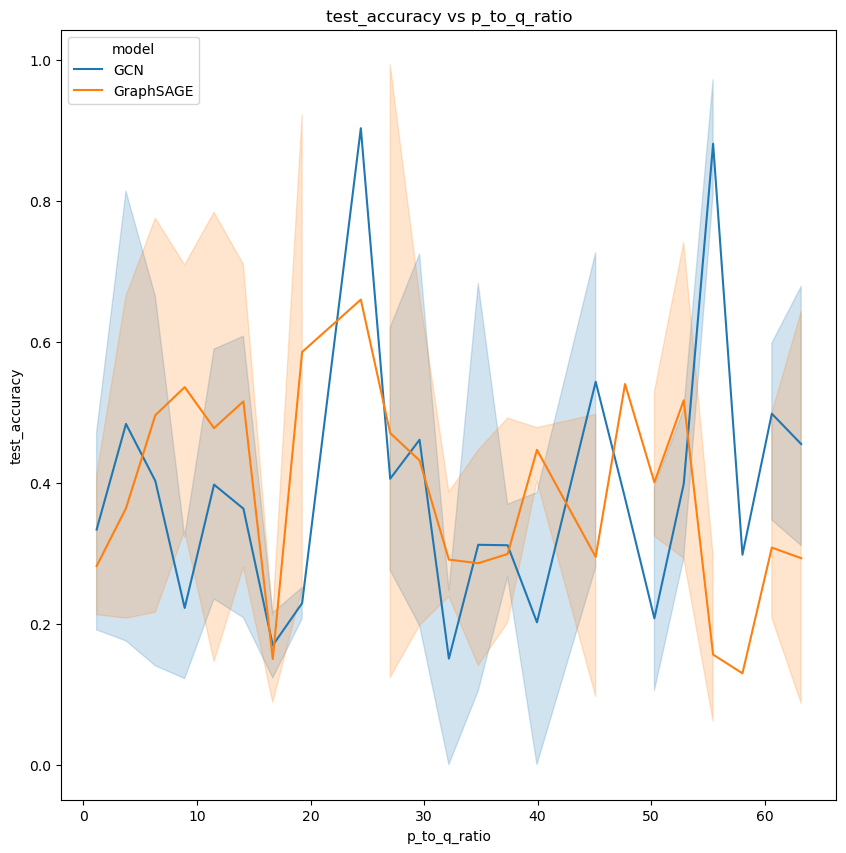

In [44]:
plot_response_surface1d('p_to_q_ratio', METRIC, results_df)